# Building a simple neural network using the nn module in PyTorch

This is a similar use case to the torch quick start at (https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html).

### Globals

In [1]:
import math
import time

import matplotlib.pyplot as plt
import torch
from torch import nn

TORCH_DEVICE = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

### Loading data

Shape of inputs (aka 'X') is torch.Size([64, 1, 28, 28])
Shape of targets (aka 'y') is torch.Size([64])


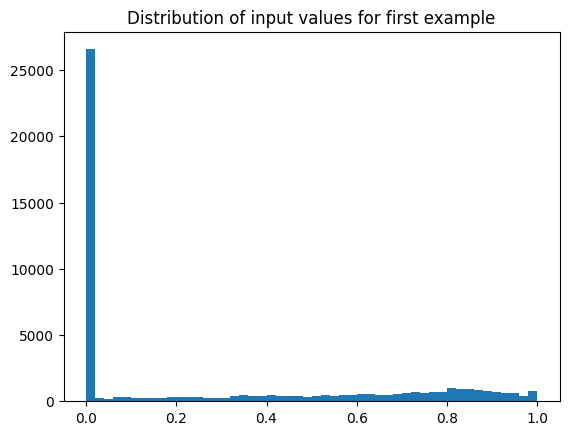

In [2]:
from torch.utils import data
from torchvision import datasets
from torchvision.transforms import ToTensor


def get_dataloader(batch_size: int, train: bool):
    mnist_dataset = datasets.FashionMNIST(
        root="data",
        train=train,
        download=True,
        transform=ToTensor(),
    )

    return data.DataLoader(mnist_dataset, batch_size=batch_size)


training_dataloader = get_dataloader(batch_size=64, train=True)
testing_dataloader = get_dataloader(batch_size=64, train=False)

for inputs, targets in training_dataloader:
    print(f"Shape of inputs (aka 'X') is {inputs.shape}")
    print(f"Shape of targets (aka 'y') is {targets.shape}")
    break

fig, axs = plt.subplots()
axs.hist(inputs.ravel(), bins=50)
axs.set_title("Distribution of input values for first example")
plt.show()

### Building the network

In [3]:
pic_height = pic_width = 28
dim_hidden = 512
dim_out = 10

class SimpleNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(pic_height * pic_width, dim_hidden),
            nn.ReLU(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.ReLU(),
            nn.Linear(dim_hidden, dim_out),
        )

    def forward(self, x):
        return self.stack(x)

In [4]:
# Testing / demonstrating the model
sample_model = SimpleNetwork().to(TORCH_DEVICE)
print(sample_model)

sample_batch_size = 100

image_shape = (1, pic_height, pic_width)
dim_in = math.prod(image_shape)
dim_hidden = 24

sample_rand_gen = torch.Generator(device=TORCH_DEVICE).manual_seed(12345678)
sample_inputs = torch.normal(mean=0, std=1, size=(sample_batch_size, 1, pic_height, pic_width), generator=sample_rand_gen, device=TORCH_DEVICE)
result = sample_model(sample_inputs)
print(f"{sample_inputs.shape=}, {result.shape=}")
assert result.shape == (sample_batch_size, dim_out)

SimpleNetwork(
  (stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=10, bias=True)
  )
)
sample_inputs.shape=torch.Size([100, 1, 28, 28]), result.shape=torch.Size([100, 10])


### Training the network

In [5]:
loss_fn = nn.CrossEntropyLoss()

In [6]:
def test(dataloader, model, loss_fn):
    all_targets = []
    all_predictions = []
    all_losses = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(TORCH_DEVICE)
            targets = targets.to(TORCH_DEVICE)
            predictions = model(inputs)
            loss = loss_fn(predictions, targets)
            all_predictions.append(predictions.argmax(dim=1))
            all_targets.append(targets)
            all_losses.append(loss)

    all_predictions = torch.cat(all_predictions)
    all_targets = torch.cat(all_targets)

    return all_targets, all_predictions, all_losses

In [7]:
model = SimpleNetwork().to(TORCH_DEVICE)

learning_rate = 1e-3
epochs = 5

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    epoch_start = time.monotonic()
    total_length = len(training_dataloader.dataset)
    count = 0
    model.train()
    for batch, (inputs, targets) in enumerate(training_dataloader):
        inputs = inputs.to(TORCH_DEVICE)
        targets = targets.to(TORCH_DEVICE)
        predictions = model(inputs)
        loss = loss_fn(predictions, targets)

        if batch % 100 == 0 or count >= total_length:
            print(f"loss: {loss.item():>7f}  [{count:>5d} / {total_length:>5d}]")

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        count += len(inputs)
    
    epoch_end = time.monotonic()
    test_targets, test_preds, test_losses = test(testing_dataloader, model, loss_fn)
    correct = (test_preds.eq(test_targets).sum() / len(test_preds)).item()
    losses = torch.tensor(test_losses)
    print(f"Test error: accuracy = {100 * correct:>0.1f}%, average loss = {losses.mean().item():>8f}")
    print(f"Epoch elapsed time = {epoch_end - epoch_start:.1f} seconds")
    print("")

Epoch 1
-------------------------------
loss: 2.290162  [    0 / 60000]
loss: 2.279153  [ 6400 / 60000]
loss: 2.269777  [12800 / 60000]
loss: 2.292797  [19200 / 60000]
loss: 2.249566  [25600 / 60000]
loss: 2.280086  [32000 / 60000]
loss: 2.273032  [38400 / 60000]
loss: 2.254985  [44800 / 60000]
loss: 2.234167  [51200 / 60000]
loss: 2.286204  [57600 / 60000]
Test error: accuracy = 26.6%, average loss = 2.221429
Epoch elapsed time = 4.1 seconds

Epoch 2
-------------------------------
loss: 2.200446  [    0 / 60000]
loss: 2.190835  [ 6400 / 60000]
loss: 2.167783  [12800 / 60000]
loss: 2.210278  [19200 / 60000]
loss: 2.126492  [25600 / 60000]
loss: 2.151556  [32000 / 60000]
loss: 2.154945  [38400 / 60000]
loss: 2.110510  [44800 / 60000]
loss: 2.091668  [51200 / 60000]
loss: 2.137179  [57600 / 60000]
Test error: accuracy = 35.7%, average loss = 2.061394
Epoch elapsed time = 3.4 seconds

Epoch 3
-------------------------------
loss: 2.042301  [    0 / 60000]
loss: 2.035684  [ 6400 / 60000]
